## Initiate the Models

In [1]:
from torch import optim

from discriminator import Discriminator
from generator import Generator
from utils import device, lr, beta1, beta2

In [2]:
gen = Generator().to(device)
disc = Discriminator().to(device)

gen_opt = optim.Adam(gen.parameters(), lr=lr, betas=(beta1, beta2))
disc_opt = optim.Adam(disc.parameters(), lr=lr, betas=(beta1, beta2))

## Load Checkpoints

In [3]:
import numpy as np
import os
from utils import checkpoint_dir, save_checkpoint, load_checkpoint

In [4]:
checkpoint_files = os.listdir(checkpoint_dir)
checkpoint_files = [a for a in checkpoint_files if (a[-4:] == '.pth')]

LOAD_MODEL = False
if len(checkpoint_files) != 0:
    LOAD_MODEL = True
    checkpoint_files.sort(key=lambda x: os.path.getmtime(checkpoint_dir + x))
    last_checkpoint = checkpoint_files[-1]
    
SAVE_MODEL = True
curr_epoch = 1 if (not LOAD_MODEL) else (load_checkpoint(last_checkpoint, (gen, disc), (gen_opt, disc_opt), lr=lr) + 1)

=> Loading  Checkpoint from epoch 100


## Training Loop

In [5]:
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from dataset import dataloader
from train import gen_step, disc_step
from utils import show_images

EPOCHS_PER_CHECKPOINT = 5

Training epoch 101


  0%|          | 0/400 [00:00<?, ?it/s]

Generator Loss: 8.50246524810791
Discriminator Loss: 0.35185474157333374



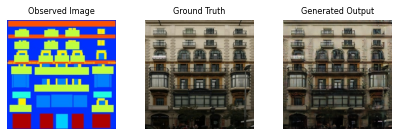

Training epoch 102


  0%|          | 0/400 [00:00<?, ?it/s]

Generator Loss: 8.870408058166504
Discriminator Loss: 0.5286402702331543



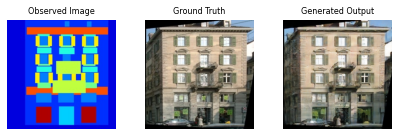

Training epoch 103


  0%|          | 0/400 [00:00<?, ?it/s]

Generator Loss: 8.263884544372559
Discriminator Loss: 0.5032057762145996



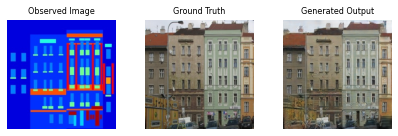

Training epoch 104


  0%|          | 0/400 [00:00<?, ?it/s]

Generator Loss: 7.22386360168457
Discriminator Loss: 0.46994683146476746



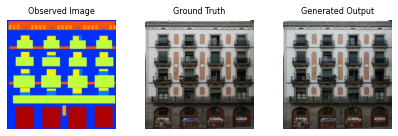

Training epoch 105


  0%|          | 0/400 [00:00<?, ?it/s]

Generator Loss: 8.116050720214844
Discriminator Loss: 0.5177221298217773



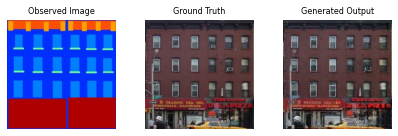

=> Saving Checkpoint
Training epoch 106


  0%|          | 0/400 [00:00<?, ?it/s]

Generator Loss: 8.039294242858887
Discriminator Loss: 0.5188772082328796



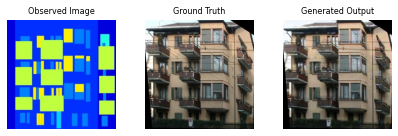

Training epoch 107


  0%|          | 0/400 [00:00<?, ?it/s]

Generator Loss: 8.337193489074707
Discriminator Loss: 0.3889540135860443



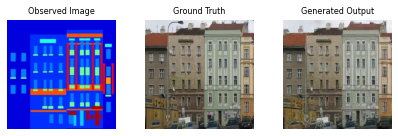

Training epoch 108


  0%|          | 0/400 [00:00<?, ?it/s]

Generator Loss: 7.825660705566406
Discriminator Loss: 0.5386276841163635



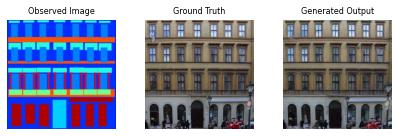

Training epoch 109


  0%|          | 0/400 [00:00<?, ?it/s]

Generator Loss: 6.131062984466553
Discriminator Loss: 0.5207600593566895



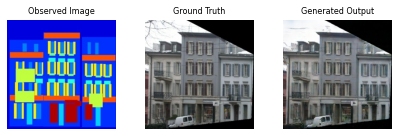

Training epoch 110


  0%|          | 0/400 [00:00<?, ?it/s]

Generator Loss: 8.191169738769531
Discriminator Loss: 0.47545477747917175



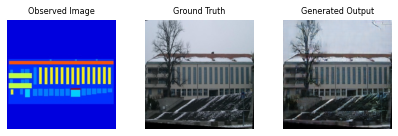

=> Saving Checkpoint
Training epoch 111


  0%|          | 0/400 [00:00<?, ?it/s]

Generator Loss: 5.687129020690918
Discriminator Loss: 0.4614742398262024



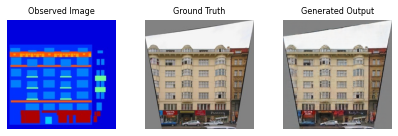

KeyboardInterrupt: 

In [6]:
for epoch in range(curr_epoch, curr_epoch + 10*EPOCHS_PER_CHECKPOINT):
    print(f"Training epoch {epoch}")
    step = 0
    for (inputs, targets), _ in tqdm(dataloader):
        step += 1
        inputs, targets = inputs.cuda(), targets.cuda()
        Disc_Loss = disc_step(inputs, targets, gen, disc, disc_opt)
        
        for i in range(2):
            Gen_Loss, generator_image = gen_step(inputs, targets, gen, disc, gen_opt)
            if (step == 1 and i == 1):
                print(f"Generator Loss: {Gen_Loss}\nDiscriminator Loss: {Disc_Loss}\n")
                show_images(inputs, targets, generator_image)
                plt.show()
    if SAVE_MODEL and epoch % EPOCHS_PER_CHECKPOINT == 0:
        filename = "checkpoint_epoch" + str(epoch)
        save_checkpoint((gen, disc), (gen_opt, disc_opt), curr_epoch=epoch, filename=filename)

## Use the Trained Model

### Load the test dataset

In [7]:
from dataset import Dataset, DataLoader, BATCH_SIZE

In [8]:
test_data_path = '../pix2pix/facades/test'

In [9]:
ds = Dataset(test_data_path, size=256, train=False)
ds.items.remove('../pix2pix/facades/test/.ipynb_checkpoints')
dataloader_test = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

### Generate one batch of images

In [10]:
gen.train=False

In [11]:
num = 10  # Number of batches to show
inps = []
outs = []
gens = []
for j in range(num):
    (inp, out), _ = next(iter(dataloader_test))
    gen_img = gen(inp.to(device))
    inps.append(inp)
    outs.append(out)
    gens.append(gen_img)

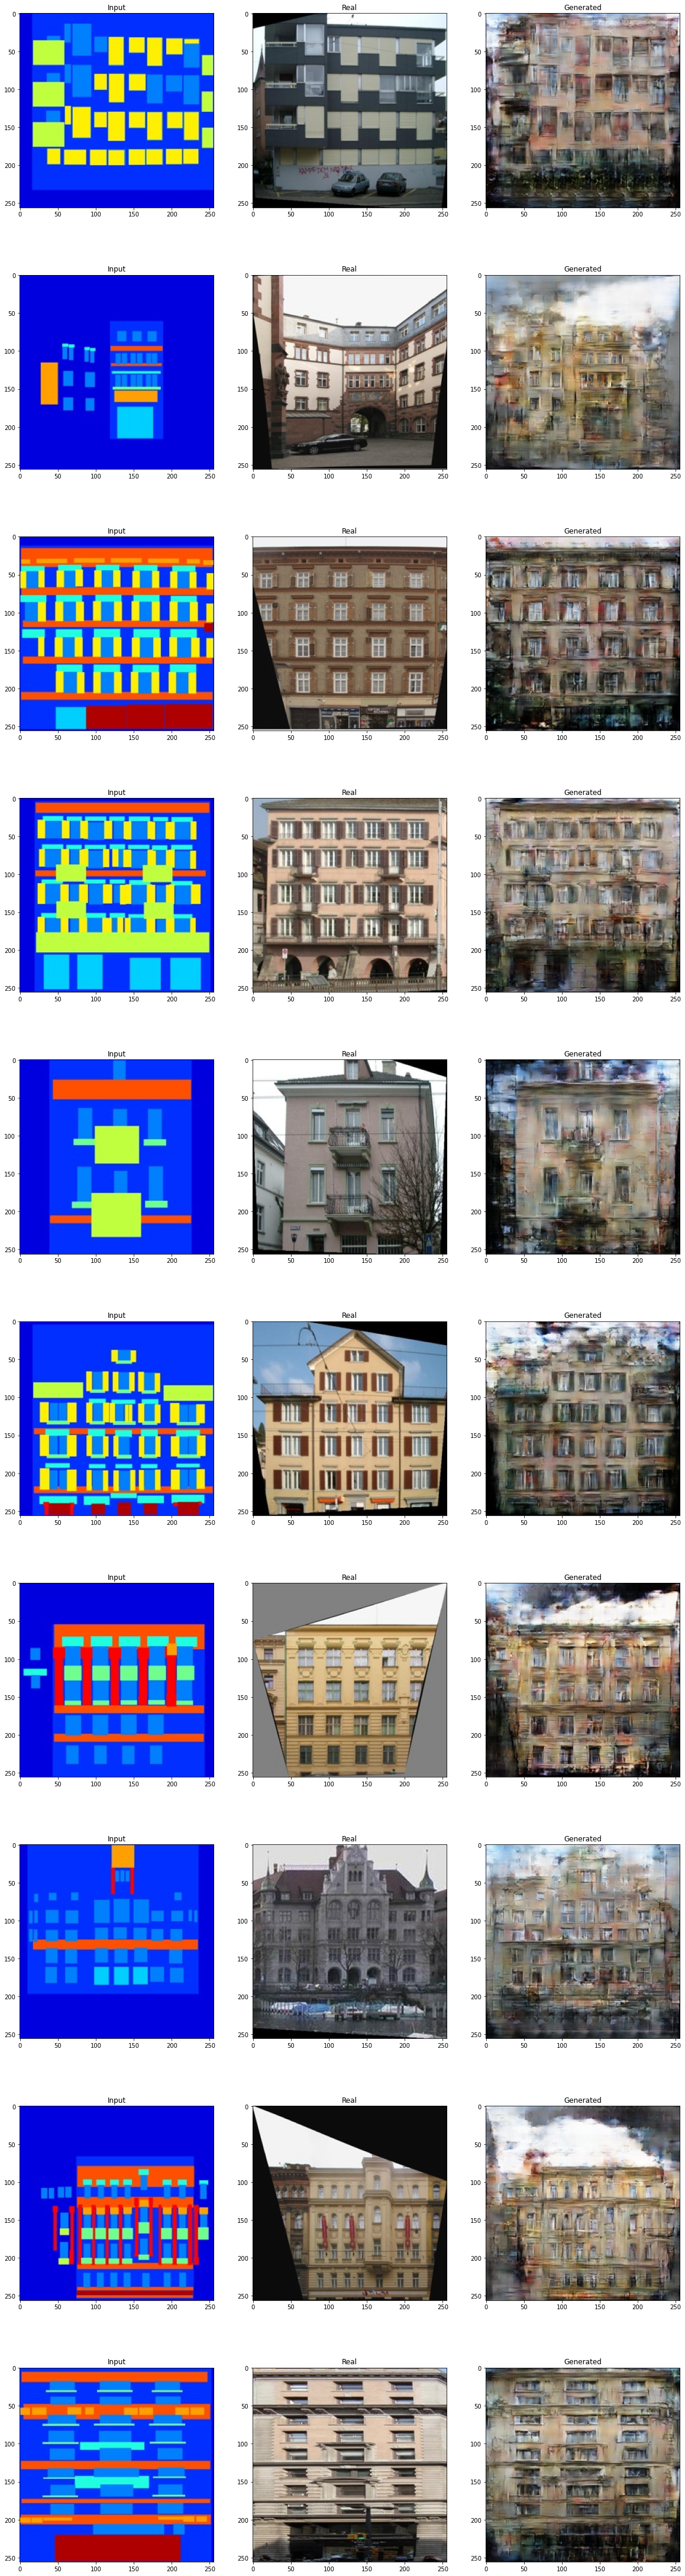

In [12]:
fig, axs = plt.subplots(num * BATCH_SIZE, 3, figsize=(20, 8 * num * BATCH_SIZE))
axs = axs.reshape(-1, 3)
j = 0  # index to keep track of number of batch we show
batch_smp = 0  # index to keep track of number of sample in each batch
for i in range(num * BATCH_SIZE):
    axs[i, 0].imshow(inps[j][batch_smp].permute(1, 2, 0) * 0.5 + 0.5)
    axs[i, 0].set_title('Input')
    axs[i, 1].imshow(outs[j][batch_smp].permute(1, 2, 0) * 0.5 + 0.5)
    axs[i, 1].set_title('Real')
    axs[i, 2].imshow(gens[j][batch_smp].detach().permute(1, 2, 0).cpu() * 0.5 + 0.5)
    axs[i, 2].set_title('Generated')
    
    batch_smp += 1
    if batch_smp == BATCH_SIZE:
        batch_smp = 0
        j += 1